<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Fastai%20NLP%20course/5_Language_Modeling_%26_Sentiment_Analysis_of_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lesson was adapted from the end of [lesson 3](https://course.fast.ai/videos/?lesson=3) and beginning of [lesson 4](https://course.fast.ai/videos/?lesson=4) of the latest fast.ai Practical Deep Learning for Coders course. We will cover all the material you need here in this notebook, so no need to have taken the Deep Learning course. Even if you have taken the DL class, we will go slower and get into more detail here!

# Language Modeling & Sentiment Analysis of IMDB movie reviews

[Video 8](https://youtu.be/PNNHaQUQqW8)

We will be looking at IMDB movie reviews. We want to determine if a review is negative or positive, based on the text. In order to do this, we will be using transfer learning.

Transfer learning has been widely used with great success in computer vision for several years, but only in the last year or so has it been successfully applied to NLP (beginning with ULMFit, which we will use here, which was built upon by BERT and GPT-2).

As Sebastian Ruder wrote in [The Gradient](https://thegradient.pub/) last summer, [NLP's ImageNet moment has arrived](https://thegradient.pub/nlp-imagenet/).


## Language Models

Language modeling can be a fun creative form. Research scientist[ Janelle Shane blogs](https://aiweirdness.com/) & [tweets](https://twitter.com/JanelleCShane) about her creative AI explorations, which often involve text. For instance, see her:

- [Why did the neural network cross the road?](https://aiweirdness.com/post/174691534037/why-did-the-neural-network-cross-the-road)
- [Try these neural network-generated recipes at your own risk.](https://aiweirdness.com/post/163878889437/try-these-neural-network-generated-recipes-at-your)
- [D&D character bios - now making slightly more sense](https://aiweirdness.com/post/183471928977/dd-character-bios-now-making-slightly-more)

**Using a GPU**

You will need to have the fastai library installed for this lesson, and you will want to use a GPU to train your neural net. If you don't have a GPU you can use in your computer (currently, only Nvidia GPUs are fully supported by the main deep learning libraries), no worries! There are a number of cloud options you can consider:

**[GPU Cloud Options](https://course.fast.ai/#using-a-gpu)**

Reminder: If you are using a cloud GPU, always be sure to shut it down when you are done!!! Otherwise, you could end up with an expensive bill!

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs = 48

### Preparing the data (on a sample)

First let's download the dataset we are going to study. The dataset has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [0]:
data_lm = TextDataBunch.from_csv(path,'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols:

- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

The correspondance from ids tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string).

In [7]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [8]:
data_lm.train_ds[0][0]

Text xxbos xxmaj by 1976 the western was an xxunk genre and the makers of this film clearly knew it . xxmaj still , instead of xxunk the project and saving us from having to watch it , they went ahead and made it anyway . xxmaj apparently in need of an interesting thread to get the audiences to come and see the film , they decided to make it as blatantly violent and unpleasant as possible . xxmaj hell , it worked for xxmaj the xxmaj wild xxmaj bunch so why should n't it work here ? xxmaj of course , xxmaj the xxmaj wild xxmaj bunch had the benefit of a superb script but the script of xxmaj the xxmaj last xxmaj hard xxmaj men is plain old - fashioned rubbish . 
 
  xxmaj it 's hard to figure out what attracted xxmaj charlton xxmaj heston and xxmaj james xxmaj coburn to their respective roles . xxmaj heston plays a retired lawman who goes after an escaped bunch of convicts led by a violent xxunk ( xxmaj coburn ) . xxmaj the hunt becomes even more personal when xxmaj heston 's daughter ( 

**But the underlying data is all numbers**

In [9]:
data_lm.train_ds[0][0].data[:10]

array([   2,    5,   48, 4743,    9,  735,   25,   50,    0,  482])

### Alternative apporach: with the data block API
We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [0]:
data = (TextList.from_csv(path,'texts.csv',cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

### Create a language model

Now let's grab the full dataset for what follows.

In [11]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab')]

In [12]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an unsup folder in train that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called wikitext-103). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

#### More about WikiText-103

We will be using the [WikiText-103](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) dataset created by [Stephen Merity](https://smerity.com/) to pre-train a language model.

To quote [Stephen's post](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/):

The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. The dataset is available under the Creative Commons Attribution-ShareAlike License.

Compared to the preprocessed version of Penn Treebank (PTB), WikiText-2 is over 2 times larger and WikiText-103 is over 110 times larger. The WikiText dataset also features a far larger vocabulary and retains the original case, punctuation and numbers - all of which are removed in PTB. As it is composed of full articles, the dataset is well suited for models that can take advantage of long term dependencies.

#### Creating the TextLMDataBunch

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [13]:
path.ls()

[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab')]

In [0]:
data_lm =(TextList.from_folder(path)
         #Input: all the text files in path)
          .filter_by_folder(include=['train','test','unsup'])
          # we may have other temp folders that contain text files so we only keep what's in train and test
          .split_by_rand_pct(0.1, seed=42)
          # We randomly split and keep 10% (10,000 reviews) for validation
          .label_for_lm()
          .databunch(bs=bs,num_workers=1))

In [15]:
len(data_lm.vocab.itos),len(data_lm.train_ds)

(60000, 90000)

We have to use a special kind of TextDataBunch for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [16]:
data_lm.show_batch()

idx,text
0,"xxmaj culver xxmaj city in the 50s and have a certain sense of reverence about the xxmaj western genre . ) \n \n xxmaj so i saw the glowing first review and decided to read "" more "" . xxmaj there i found several reviews with 1 or 2 stars that summed up my feelings well about the lack of character development , poor editing , feeling that it"
1,"13 , "" xxmaj drop xxmaj dead xxmaj gorgeous "" , an incredibly toxic poison was supposedly used to kill the victim . xxmaj this was so toxic and killed so quickly the victim had no time to run or even scream for help . xxmaj yet there was no plausible explanation for how the killer obtained such a powerful poison . \n \n xxmaj in episode 15 ,"
2,"upon the public . \n \n i 've seen a lot of hateful topics on the forums for this show , and i do n't agree with "" xxmaj mencia 's "" detractors . xxmaj this is not an awful show . xxmaj it had me crying in laughter a few times . xxmaj when it 's funny , it 's very , very funny . xxmaj yes ,"
3,"time to stop stereotyping xxmaj singaporeans and making such films . xxmaj some of the actors / actresses actually have talent , but sadly it was n't shown much in this film . i was fidgeting in my seat when i watched this , being quite young at that time , my parents dragged me along to see it . xxmaj honestly i could say that i was going to"
4,"him to ' snap out of it ! ' . xxmaj his brother is a much more human character . xxmaj the ending is inconclusive and puzzling . xxmaj everyone in the cinema ( when i saw the film ) went out muttering about how they nearly fell asleep . xxmaj of course , it should n't have to be a xxmaj hollywood xxmaj bruce xxmaj willis - style '"


Let's save our databunch for next time:

In [0]:
data_lm.save('lm_databunch')

#### Loading saved data, and creating the language model

In the future we can load the data:

In [0]:
data_lm = load_data(path,'lm_databunch',bs=bs)

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in ~/.fastai/models/ (or elsewhere if you specified different paths in your config file).

In [0]:
learn_lm = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.3)

In [0]:
vocab = data_lm.vocab

In [21]:
vocab.stoi['stingray']

35747

In [22]:
vocab.itos[vocab.stoi['stingray']]

'stingray'

In [23]:
vocab.itos[vocab.stoi['mobula']]

'xxunk'

In [0]:
awd = learn_lm.model[0]

In [0]:
from scipy.spatial.distance import cosine as dist

In [0]:
enc = learn_lm.model[0].encoder

In [27]:
enc.weight.size()

torch.Size([60000, 400])

#### Difference in vocabulary between IMDB and Wikipedia

We are going to load wiki_itos, which can be downloaded along with wikitext-103. We will compare the vocabulary from wikitext with the vocabulary in IMDB. It is to be expected that the two sets have some different vocabulary words, and that is no problem for transfer learning!

In [28]:
!wget http://files.fast.ai/models/wt103/itos_wt103.pkl

--2019-08-03 11:09:35--  http://files.fast.ai/models/wt103/itos_wt103.pkl
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161252 (4.0M)
Saving to: ‘itos_wt103.pkl’

itos_wt103.pkl      100%[===================>]   3.97M  18.6MB/s    in 0.2s    

2019-08-03 11:09:35 (18.6 MB/s) - ‘itos_wt103.pkl’ saved [4161252/4161252]



In [0]:
wiki_itos = pickle.load(open('/content/itos_wt103.pkl', 'rb'))

In [30]:
wiki_itos[:10]

['_unk_', '_pad_', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a']

In [31]:
len(wiki_itos)

238462

In [32]:
len(vocab.itos)

60000

In [0]:
wiki_words = set(wiki_itos)

In [0]:
imdb_words = set(vocab.itos)

In [0]:
wiki_not_imbdb = wiki_words.difference(imdb_words)

In [0]:
imdb_not_wiki = imdb_words.difference(wiki_words)

In [0]:
wiki_not_imdb_list = []

for i in range(100):
    word = wiki_not_imbdb.pop()
    wiki_not_imdb_list.append(word)
    wiki_not_imbdb.add(word)

In [38]:
wiki_not_imdb_list[:15]

['utvikling',
 'iveco',
 'glf',
 'eskridge',
 'nellyville',
 'ostinatos',
 'gelb',
 'eais',
 'unpreserved',
 'ifriqiya',
 'soundwaves',
 'ettingshausen',
 'revelator',
 '80-yard',
 'bulsara']

In [0]:
imdb_not_wiki_list = []

for i in range(100):
    word = imdb_not_wiki.pop()
    imdb_not_wiki_list.append(word)
    imdb_not_wiki.add(word)

In [40]:
imdb_not_wiki_list[:15]

['melodramatics',
 'lommel',
 'movie--',
 "i'ts",
 'tamie',
 'bullit',
 'flunk',
 'waaay',
 'olenska',
 'sawy',
 'bruhl',
 'ceddie',
 'zadora',
 'nightie',
 'hankies']

All words that appear in the IMDB vocab, but not the wikitext-103 vocab, will be initialized to the same random vector in a model. As the model trains, we will learn these weights.

In [41]:
vocab.stoi['modernisation']

0

In [42]:
"modernisation" in wiki_words

True

In [43]:
vocab.stoi['30-something']

28149

In [44]:
"30-something" in wiki_words, "30-something" in imdb_words

(False, True)

In [45]:
vocab.stoi["linklater"]

16236

In [46]:
"linklater" in wiki_words, "linklater" in imdb_words

(True, True)

In [47]:
"house" in wiki_words, "house" in imdb_words

(True, True)

Here we got these word embeddings .this "30-something" weights are randomized the same in both wiki_words and idmb_words

In [48]:
enc.weight[vocab.stoi["30-something"],:]

tensor([ 2.5335e-02,  2.5928e-03,  4.2274e-02, -2.7408e-02, -1.1007e-02,
        -9.9722e-03, -6.2764e-02,  1.7945e-01, -1.2754e-01, -2.0963e-01,
        -1.2412e-02, -5.5517e-03, -5.0497e-02, -5.0132e-02, -4.2822e-02,
         1.7264e-01, -6.5040e-02, -5.7076e-02, -1.1030e-01,  1.8643e-02,
         5.2707e-03, -5.8765e-03,  2.9932e-02,  1.9212e-02, -2.3984e-02,
         1.4320e-01, -1.0635e-01, -9.7421e-03,  1.0035e-02, -3.9903e-02,
         2.8231e-02,  3.1862e-02,  1.2975e-01,  6.8744e-02, -4.6620e-03,
         1.6759e-02,  2.0085e-02,  1.3458e-01, -3.3566e-02, -4.4917e-02,
         2.6531e-02, -7.5612e-02, -2.2491e-02,  1.9583e-02,  2.2083e-02,
         2.1363e-02,  7.7305e-03, -1.3112e-01, -1.3569e-01, -1.2799e-02,
         7.3783e-02, -9.0277e-03,  1.6603e-02,  2.6821e-02,  4.5240e-02,
         1.6859e-02, -1.9772e-01,  1.6632e-02,  4.5093e-02, -8.1135e-03,
         5.8933e-02, -2.6548e-02, -8.7136e-03, -2.9872e-02,  4.2180e-02,
        -4.1535e-02, -6.2623e-02,  2.0562e-02, -3.0

In [49]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["linklater"], :])

True

In [50]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["house"], :])

False

In [0]:
new_word_vec = enc.weight[vocab.stoi["linklater"], :]

#### Generating fake movie reviews (using wiki-text model)

Note that learn_lm  is not trained then the model is purely used by Wiki-text

In [0]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [53]:
print("\n".join(learn_lm.predict(TEXT,N_WORDS,temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is changed to indicate a location where the station 's colours are raised . This has been used to define stranded weather . This is because of the relationship between the two architecture and a light state , to
The color of the sky is visible in sky sky . The sky has the sky in the air ( and the sky ) , and the sky is blue , which is reflected in the visual image of the sky . The sky


In [0]:
TEXT = "I hated this movie"
N_WORDS = 30
N_SENTENCES = 2

In [55]:
print("\n".join(learn_lm.predict(TEXT,N_WORDS,temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie ? The Hollywood Reporter said , " It 's going to be a good episode " . The author of the book Something to
I hated this movie and its sequels , saying that it was the first time that the movie was shown in the U.S. . In addition to the film , the


In [56]:
print("\n".join(learn_lm.predict(TEXT,N_WORDS,temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie = 
 
  " i ' m a movie reporter " , is one of the only films shown in the United States to be in English .
I hated this movie as a movie , because it is the first film about what he called a " great company " . Although he has described the movie as " a


In [57]:
doc(LanguageLearner.predict)

In [58]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon , and he said , " i ' m not sure what i ' m doing . It 's not a movie .
I hated this movie by James Bond . He said , " It 's a great film . It 's a great film . It 's a great


In [59]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon , and he said he was " a fan of the Beatles " . He said that he was " very proud of
I hated this movie by John Lennon , and he said , " It 's a bad thing to do . It 's a bad thing . " The


#### Training the model
Now, we want to choose a good learning rate.

In [60]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


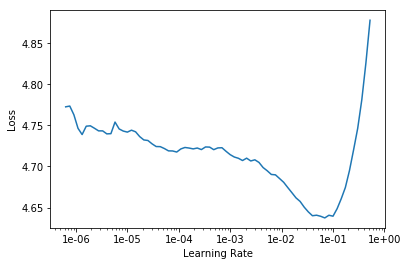

In [61]:
learn_lm.recorder.plot(skip_end=15)

In [0]:
lr = 1e-3
lr *= bs/48

In [0]:
learn_lm.to_fp16();

In [64]:
learn_lm.fit_one_cycle(1,lr*10,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.148908,4.095057,0.171429,19:04


Since this is relatively slow to train, we will save our weights:

In [0]:
learn_lm.save('fit_1')

In [0]:
learn_lm.load('fit_1');


To complete the fine-tuning, we can then unfreeze and launch a new training.

```
The key thing with transfer learning is that typically when you first start fine-tuning it on your dataset, you just want to train the last few layers  and keep the earlier layers frozen which means you are not going to update weights for these earlier layers. Then you will unfreeze those and update all the weights. This is kind of something that helps it learn faster. So here I am going to load in this already
```

In [0]:
learn_lm.unfreeze()

In [69]:
learn_lm.fit_one_cycle(4,lr,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.828491,3.627628,0.257143,21:54
1,3.769386,3.633922,0.271429,21:55
2,3.647970,3.455968,0.257143,22:51
3,3.549844,3.481542,0.285714,21:59


In [0]:
learn_lm.save('fine_tuned')

We have to save not just the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn_lm.save_encoder('fine-tuned_enc')


**Loading our saved weights**

In [0]:
learn_lm.load('fine_tuned');

Now that we've trained our model, different representations have been learned for the words that were in IMDB but not wiki (remember that at the beginning we had initialized them all to the same thing):

In [0]:
enc = learn_lm.model[0].encoder

In [74]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["linklater"], :])

False

In [75]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], new_word_vec)

False

#### More generated movie reviews

How good is our model? Well let's try to see what it predicts after a few given words.

Note that learn_lm  is now trained with Imdb dataset.

In [0]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [77]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because of its roots in Warner Bros. The movie is very well acted and shot . It is very well - acted by all the actors and is a very good film . The actors do
i liked this movie because of the fact that it was a very historically accurate movie . i do know that it was made for TV but this is a very well - made movie . This movie is a very good movie


In [0]:
TEXT = "This movie was"
N_WORDS = 30
N_SENTENCES = 2

In [79]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie was pretty good . i think it was a funny movie , and it does n't have it 's " wit " . The movie is a parody of the
This movie was so bad that i had to turn it off . It is so bad it 's almost funny . The direction is just awful . There 's


In [0]:
TEXT = "I hated this movie"
N_WORDS = 40
N_SENTENCES = 2

In [81]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie . In the first six minutes it was okay . The movie starts off slowly , with a lot of good comedy , because it tries to be hilarious , but never comes to the level of being
I hated this movie . It starts out like an old TV movie and Bill Paxton ( Bill Paxton ) plays an ex - con who has a hard time with the girl i saw . After


### Risks of language models

We will talk about ethical concerns raised by very accurate language models in lesson 7, but here are a few brief notes:

In reference to [OpenAI's GPT-2](https://www.theverge.com/2019/2/14/18224704/ai-machine-learning-language-models-read-write-openai-gpt2): Jeremy Howard said, I’ve been trying to warn people about this for a while. We have the technology to totally fill Twitter, email, and the web up with reasonable-sounding, context-appropriate prose, which would drown out all other speech and be impossible to filter.

For a small example, consider when completely incorrect (but reasonable sounding) ML generated answers were [posted to StackOverflow](https://meta.stackoverflow.com/questions/384596/completely-incorrect-machine-learning-generated-answers?stw=2):

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/robot-overflow.png)

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/husain-tweet.png)

In [119]:
import gc
gc.collect()

0

In [0]:
torch.cuda.empty_cache()

In [122]:
from fastai.utils.mem import gpu_mem_get_all
gpu_mem_get_all()

[GPUMemory(total=15079, free=1130, used=13948)]

## Create a Classifier [Video 9](https://youtu.be/5gCQvuznKn0?t=5377)

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
bs = 48

In [0]:
data_clas = (TextList.from_folder(path,vocab= data_lm.vocab)
            #grab all the text files in path)
             .split_by_folder(valid='text')
             # #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg','pos'])
             #label them all with their folders
             .databunch(bs=bs,num_workers=1))

In [0]:
data_clas.save('imdb_textlist_class')


In [0]:
data_clas = load_data(path,"imdb_textlist_class",bs=bs,num_workers=1)

In [104]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos xxmaj heavy - handed moralism . xxmaj writers using characters as mouthpieces to speak for themselves . xxmaj predictable , plodding plot points ( say that five times fast ) . a child 's imitation of xxmaj britney xxmaj spears . xxmaj this film has all the earmarks of a xxmaj lifetime xxmaj special reject . \n \n i honestly believe that xxmaj jesus xxmaj xxunk and xxmaj",neg
"xxbos xxmaj the freedom of having your own xxmaj sea xxmaj going xxmaj power xxmaj boat , the excitement of going on underwater adventures a rugged , an 's man of an adventurer and xxunk so well endowed ! ) assistants in fine xxmaj bikinis were all definite selling points for "" xxup sea xxup xxunk - 61 ) . \n \n xxmaj just what was the reason for",pos
"xxbos xxmaj by 1987 xxmaj hong xxmaj kong had given the world such films as xxmaj sammo xxmaj hung 's ` xxmaj encounters of the xxmaj spooky xxmaj kind ' xxmaj chow xxmaj yun xxmaj fat in xxmaj john xxmaj woo 's iconic ` a xxmaj better xxmaj tomorrow ' , ` xxmaj zu xxmaj warriors ' and the classic ` xxmaj mr xxmaj vampire ' . xxmaj jackie xxmaj",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn_c = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.3)#.to_fp16()
learn_c.load_encoder('fine-tuned_enc')
learn_c.freeze()

In [107]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


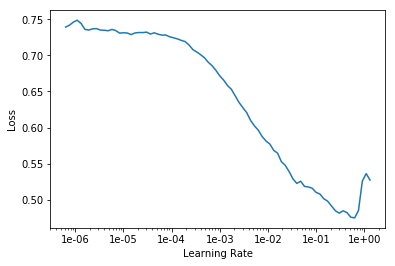

In [108]:
learn_c.recorder.plot()

In [112]:
learn_c.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [0]:
learn_c.save('first')

In [0]:
learn_c.load('first')

In [0]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))


In [0]:
learn_c.save('2nd')

In [0]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [0]:
learn_c.save('3rd')

In [0]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [0]:
learn_c.save('clas')

In [0]:
learn_c.predict("I really loved that movie, it was awesome!")

In [0]:
learn_c.predict("I didn't really love that movie, and I didn't think it was awesome.")

# Language Model Zoo

fast.ai alumni have applied ULMFit to dozens of different languages, and have beat the SOTA in Thai, Polish, German, Indonesian, Hindi, & Malay.

They share tips and best practices in [this forum thread](https://forums.fast.ai/t/language-model-zoo-gorilla/14623) in case you are interested in getting involved!

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/language_model_zoo.png)